In [54]:
# this could be rewritten to take in the function as an argument
def binary_operator(name,u,v):
    
    def operator_hadamard(u, v):
        return u * v

    def operator_l1(u, v):
        return np.abs(u - v)

    def operator_l2(u, v):
        return (u - v) ** 2

    def operator_avg(u, v):
        return (u + v) / 2.0

    if name=="hadamard":
        return operator_hadamard(u,v)
    elif name=="l1":
        return operator_l1(u,v)
    elif name=="average":
        return operator_avg(u,v)
    elif name=="l2":
        return operator_l2(u,v)
    

In [55]:
import pandas as pd
import pickle


In [56]:
from py2neo import  Graph, Node

graphdb = Graph(scheme="bolt", host="localhost", port=7687, secure=False, auth=('neo4j', 'test'))


In [57]:
# create a graph projection
graphdb.run("""CALL gds.graph.create('early_graph',
    'Author', 
    {
        CO_AUTHOR_EARLY: {
                type: 'CO_AUTHOR_EARLY',
                orientation: 'UNDIRECTED'
                }
                }
                )""")

In [58]:
# create a graph projection
graphdb.run("""CALL gds.graph.create('late_graph',
    'Author', 
    {
        CO_AUTHOR: {
                type: 'CO_AUTHOR',
                orientation: 'UNDIRECTED'
                }
                }
                )""")

In [60]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="link_benchmark")

In [61]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("link_benchmark") \
    .getOrCreate()


In [330]:
test_df=pd.read_csv("/home/areias/Documents/DataScience/graphs/data/testdf.csv")
training_df=pd.read_csv("/home/areias/Documents/DataScience/graphs/data/trainingdf.csv")

In [331]:
training_data=spark.createDataFrame(training_df)

In [332]:
test_data=spark.createDataFrame(test_df)

In [333]:
import gensim.models
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import StructField, StructType,IntegerType

def apply_node2vec_features(data, graph_name, walk_length, num_walks, dimensions, 
                            window_size, p, q, num_iter, workers, operator_name,
                            output_col_name):
    
    params = {
    "pairs": [{"node1": row["node1"], "node2": row["node2"]}
    for row in data.collect()],
    "steps": walk_length,
    "walks": num_walks,
    "size": dimensions,
    "graph_name": graph_name,
    "mode":"node2vec",
    "inOut":q,
    "return":p
    }

    query=("""
    UNWIND $pairs as pair
    MATCH (p:Author) WHERE id(p) = pair.node1 OR id(p) = pair.node2
    WITH DISTINCT p
    CALL gds.alpha.randomWalk.stream($graph_name,{
        start: id(p),
        steps: $steps,
        walks: $walks,
        mode: $mode,
        inOut: $inOut,
        return: $return        
    })
    YIELD nodeIds
    RETURN [id in nodeIds | toString(id)] as walks
    """)

    random_walks=graphdb.run(query, params).to_series()
    
    model=gensim.models.Word2Vec(random_walks, sg=1, window=window_size, size=dimensions, min_count=1,
                                 workers=workers,iter=num_iter)

    vectors=[{"node1":row["node1"],
            "node2": row["node2"],
            output_col_name: Vectors.dense(
                binary_operator(operator_name, model.wv[str(row["node1"])], model.wv[str(row["node2"])]))
            } for row in data.collect()]
    
    schema = StructType([
        StructField('node1', IntegerType()),
        StructField('node2', IntegerType()),
        StructField(output_col_name, VectorUDT())])

    features=spark.createDataFrame(vectors, schema)
    return data.join(features, ["node1", "node2"])

In [334]:
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = 2
operator_name="l1"
p=1
q=1

In [553]:
from sklearn.model_selection import ParameterGrid
grid = [{'p': [0.25,0.5,1,2],'q': [4]}]
list(ParameterGrid(grid))

[{'p': 0.25, 'q': 4}, {'p': 0.5, 'q': 4}, {'p': 1, 'q': 4}, {'p': 2, 'q': 4}]

In [13]:
for item in enumerate(ParameterGrid(grid)):
    model_name="model"+str(item[0])
    training_data = apply_node2vec_features(training_data, 'early_graph', walk_length, num_walks, dimensions, 
                            window_size, item[1]['p'], item[1]['q'], num_iter, workers, operator_name,
                            model_name)
    test_data = apply_node2vec_features(test_data, 'late_graph', walk_length, num_walks, dimensions, 
                            window_size, item[1]['p'], item[1]['q'], num_iter, workers, operator_name,
                            model_name)


[{'p': 2, 'q': 2}]

In [336]:
dimensions=10

In [337]:
import numpy as np
training_data = apply_node2vec_features(training_data, 'early_graph', walk_length, num_walks, dimensions, 
                        window_size, p, q, num_iter, workers, operator_name,
                        "model0")
test_data = apply_node2vec_features(test_data, 'late_graph', walk_length, num_walks, dimensions, 
                        window_size, p, q, num_iter, workers, operator_name,
                        "model0")

In [338]:
from pyspark.ml.feature import RFormula

rForm = RFormula()

from pyspark.ml.tuning import ParamGridBuilder
params = ParamGridBuilder()\
    .addGrid(rForm.formula, ["label ~ model"+str(i) for i in range(1)])\
    .build()



In [339]:
import mycrossvalidator as mycv

In [342]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

rf = RandomForestClassifier(labelCol="label", 
        featuresCol="features",
        numTrees=30, maxDepth=10)

stages=[rForm, rf]
pipeline=Pipeline().setStages(stages)

In [343]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderROC")\
    .setRawPredictionCol("prediction")\
    .setLabelCol("label")

In [344]:
cv = mycv.MyCrossValidator()\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params)\
    .setCollectSubModels(True)

In [345]:
from pyspark.sql.functions import lit

In [346]:
training_data=training_data.withColumn("fold",lit(0))
training_data=training_data.withColumn("test",lit(0))

In [347]:
test_data=test_data.withColumn("fold",lit(0))
test_data=test_data.withColumn("test",lit(1))

In [348]:
all_df=training_data.union(test_data)

In [349]:
mycvfitted, foldstats = cv.fit(all_df)

In [350]:
mycvfitted.avgMetrics

[0.8421214924452667]

In [514]:
from collections import defaultdict

pq_results=defaultdict(list)

for q in [0.25, 0.50, 1,2]:
    with open("/home/areias/Documents/DataScience/graphs/model"+str(q).replace(".","_")+".pkl",'rb') as f:
            pq_results[q]=pickle.load(f)

In [ ]:
with open("/home/areias/Documents/DataScience/graphs/model4.pkl",'rb') as f:
            pq_results[q]=pickle.load(f)

In [515]:
df=pd.DataFrame.from_dict(pq_results,orient='index',
                         columns=['0.25', '0.50', '1', '2'])
df['q']=df.index

In [516]:
df

,0.25,0.50,1,2,q
0.25,0.841967,0.801418,0.784613,0.735739,0.25
0.50,0.859544,0.821307,0.774591,0.805581,0.50
1.00,0.881129,0.854456,0.833179,0.825933,1.00
2.00,0.894696,0.871107,0.869874,0.852760,2.00


In [517]:
df=pd.melt(df,'q')

In [518]:
df.columns=['q','p','auc']

In [529]:
df.groupby('p')['auc'].mean()

p
0.25    0.869334
0.50    0.837072
1       0.815564
2       0.805003
Name: auc, dtype: float64

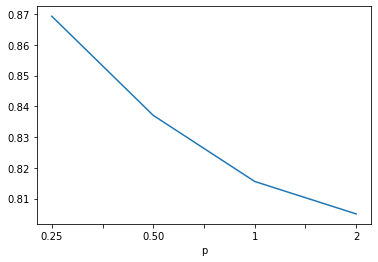

In [519]:
df.groupby('p')['auc'].mean().plot()

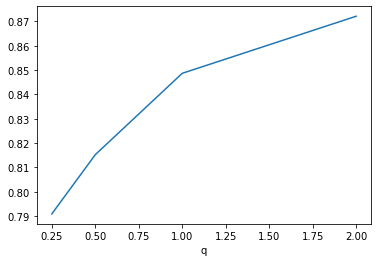

In [520]:
df.groupby('q')['auc'].mean().plot()

In [549]:
df.set_index('q', inplace=True)

Text(0.5, 1.0, 'ROC AUC over InOut (q) and Return (p) Parameters')

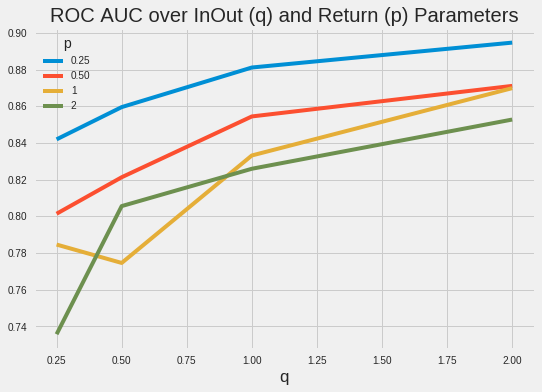

In [552]:
import matplotlib.pyplot as plt 
df.groupby('p')['auc'].plot(legend=True)
plt.legend(title="p")
plt.title("ROC AUC over InOut (q) and Return (p) Parameters")

In [289]:
# high q and low p is best 


walks=list(range(6,22,2))
length=list(range(40,110,10))
dimensions=[ i * i for i in range(4,9)]
window=list(range(8,22,2))

In [260]:
num_iter = 1
workers = 2
operator_name="l1"

In [ ]:
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
p=1
q=1




In [290]:
dimensions

[16, 25, 36, 49, 64]

In [291]:
walks

[6, 8, 10, 12, 14, 16, 18, 20]

In [292]:
window

[8, 10, 12, 14, 16, 18, 20]

In [293]:
length

[40, 50, 60, 70, 80, 90, 100]

In [294]:
grid = [{'p': [1],
         'q': [1],
        'window': [10],
        'dimensions': dimensions,
        'walks': [10],
        'length': [80]}]
list(ParameterGrid(grid))

[{'dimensions': 16, 'length': 80, 'p': 1, 'q': 1, 'walks': 10, 'window': 10},
 {'dimensions': 25, 'length': 80, 'p': 1, 'q': 1, 'walks': 10, 'window': 10},
 {'dimensions': 36, 'length': 80, 'p': 1, 'q': 1, 'walks': 10, 'window': 10},
 {'dimensions': 49, 'length': 80, 'p': 1, 'q': 1, 'walks': 10, 'window': 10},
 {'dimensions': 64, 'length': 80, 'p': 1, 'q': 1, 'walks': 10, 'window': 10}]

In [310]:
# default params
num_iter = 1
workers = 2
operator_name="l1"
dimensions = [128]
num_walks = [10]
walk_length = [80]
window_size = [10]
p=1
q=1

# test params
num_walks=list(range(6,22,2))
#walk_length=list(range(40,110,10))
#dimensions=[ i * i for i in range(4,9)]
window_size=list(range(8,22,2))

grid = [{'window_size': window_size,
        'dimensions': dimensions,
        'walks': num_walks,
        'length': walk_length}]

In [315]:
list(range(len(list(ParameterGrid(grid)))))

[0, 1, 2, 3, 4, 5, 6, 7]

In [307]:
for item in enumerate(ParameterGrid(grid)):
    print(item[1]['walks'])


6
8
10
12
14
16
18
20


In [ ]:
training_data = apply_node2vec_features(training_data, 'early_graph', item[1]['length'], item[1]['walks'], 
                                        item[1]['dimensions'], item[1]['window_size'], 1, 1, 
                                        num_iter, workers, operator_name,"model0")

## Dimensions

In [483]:
with open("/home/areias/Documents/DataScience/graphs/model_dimensions.pkl",'rb') as f:
            dimension_results=pickle.load(f)

In [485]:
dimensions=[ i * i for i in range(4,9)]
dimensions=dimensions+[128]

In [486]:
with open("/home/areias/Documents/DataScience/graphs/model1.pkl",'rb') as f:
            other=pickle.load(f)

In [489]:
# entry for p=1 
dimension_results=dimension_results+[other[2]]

Text(0.5, 1.0, 'ROC AUC for different dimension sizes')

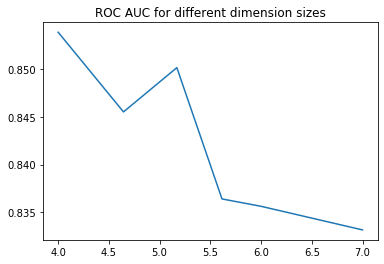

In [370]:
plt.plot(np.log2(dimensions+[128]),results+[other[2]])
plt.title("ROC AUC for different dimension sizes")

# Number of walks

In [372]:
len(walks)/2

4.0

In [395]:
for i, v in zip(list(range(0,len(walks),int(len(walks)/2))),['part1','part2']):
    filename="/home/areias/Documents/DataScience/graphs/model"+"_walks"+v+".pkl"
    print(i,v,filename)

0 part1 /home/areias/Documents/DataScience/graphs/model_walkspart1.pkl
4 part2 /home/areias/Documents/DataScience/graphs/model_walkspart2.pkl


In [495]:
walks

[6, 8, 10, 12, 14, 16, 18, 20]

In [391]:
i=0
walks[i:i+int(len(walks)/2)]

[6, 8, 10, 12]

In [392]:
i=4
walks[i:i+int(len(walks)/2)]

[14, 16, 18, 20]

In [492]:
walk_results=[]
for part in ['part1','part2']:
    with open("/home/areias/Documents/DataScience/graphs/model_walks"+part+".pkl",'rb') as f:
            walk_results=walk_results+(pickle.load(f))


Text(0.5, 1.0, 'ROC AUC for different walk sizes')

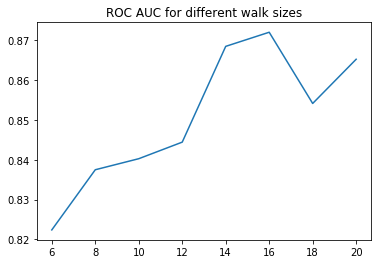

In [493]:
plt.plot(walks,walk_results)
plt.title("ROC AUC for different walk sizes")

In [403]:
results

[0.8223866790009251,
 0.8374961455442491,
 0.8402713536848597,
 0.8444341658957755,
 0.868485969781067,
 0.8720320690718472,
 0.8541473943879124,
 0.8652482269503546]

In [473]:
## Length of walks
length_results=[]
for part in ['part1','part2']:
    with open("/home/areias/Documents/DataScience/graphs/model_length"+part+".pkl",'rb') as f:
            length_results=length_results+(pickle.load(f))


In [467]:
walk_length=list(range(40,110,10))

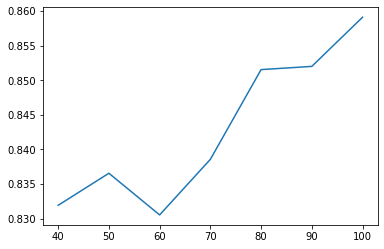

In [474]:
plt.plot(walk_length,length_results)

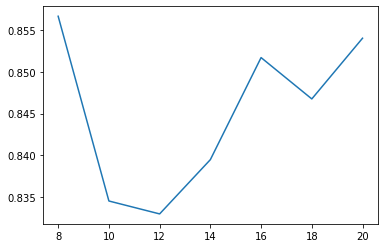

In [472]:
## Window size
window_results=[]
for part in ['part1','part2']:
    with open("/home/areias/Documents/DataScience/graphs/model_window"+part+".pkl",'rb') as f:
            window_results=window_results+(pickle.load(f))

plt.plot(window_size,window_results)

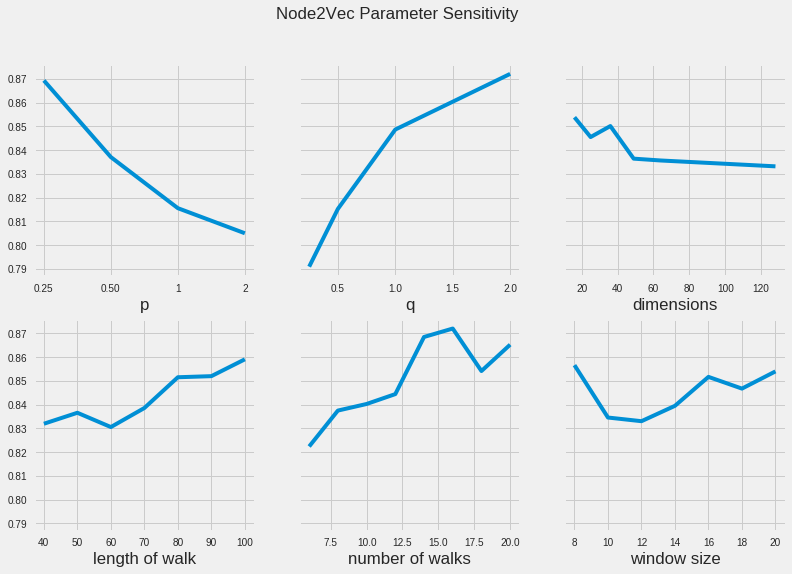

In [551]:
plt.style.use('fivethirtyeight')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, sharey=True,figsize=(12,8))
fig.suptitle('Node2Vec Parameter Sensitivity')

ax1.plot(df.groupby('p')['auc'].mean())
ax1.set_xlabel("p")

ax2.plot(df.groupby('q')['auc'].mean())
ax2.set_xlabel("q")

ax3.plot(dimensions, dimension_results)
ax3.set_xlabel("dimensions")

ax4.plot(walk_length, length_results)
ax4.set_xlabel("length of walk")

ax5.plot(walks, walk_results)
ax5.set_xlabel("number of walks")

ax6.plot(window_size, window_results)
ax6.set_xlabel("window size")

plt.show()